## Final Assignment - Intrusion detection

### Introduction 
Security is an important issue in today's environments.  
An intrusion detection system (IDS) is a model that can be used to analyze anomalous behavior in a network. NSL-KDD is the updated version of KDD cup 99 dataset. It is used as a benchmark for researchers  to compare different types of Intrusion detection system (IDS) methods or build an intrusion detection system.  
An in depth analysis of the original dataset can be found on this [Tavallaee et al.](https://www.researchgate.net/publication/48446353_A_detailed_analysis_of_the_KDD_CUP_99_data_set) and [Rawat et al.](https://arxiv.org/abs/1910.01114)

In [107]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
train_df = pd.read_csv('NSL-KDDTrain.csv')
test_df = pd.read_csv('NSL-KDDTest.csv')

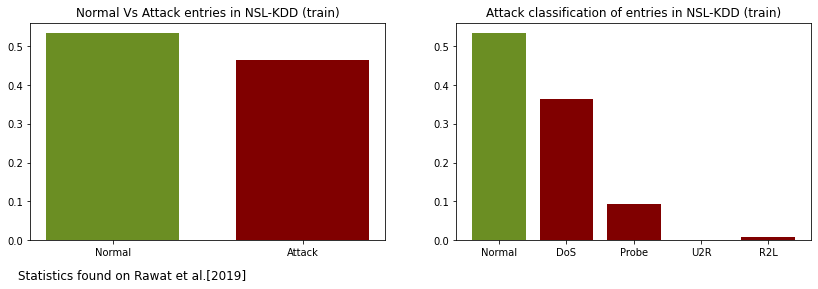

In [3]:
normal_attack = ['Normal', 'Attack']
normal_attack_height = [67343/train_df.shape[0], (train_df.shape[0]-67347)/train_df.shape[0]]

attack_type = ['Normal', 'DoS', 'Probe', 'U2R', 'R2L']
attack_type_height = [67343/train_df.shape[0], 45927/train_df.shape[0], 11656/train_df.shape[0], 52/train_df.shape[0] , 995/train_df.shape[0]]

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.bar(x=normal_attack, height=normal_attack_height, width=0.7, color=['olivedrab','maroon'])
plt.title('Normal Vs Attack entries in NSL-KDD (train)')
plt.text(x=-0.5, y=-0.1, s='Statistics found on Rawat et al.[2019]', fontsize=12)

plt.subplot(122)
plt.bar(x=attack_type, height=attack_type_height, color=['olivedrab'] + ['maroon']*4)
plt.title('Attack classification of entries in NSL-KDD (train)');

As suggested by the information presented in the graphs above, there is approximately the same number of attack and normal labels.   
So, to tackle the problem in an unlabel manner clustering techniques are suitable. Techniques that cluster the data either into two or five clusters can be used.  
A good clustering algorithm results in high intra cluster similarity and low inter cluster similarity. There are three major types of clustering
process according to the way they organize data:  
* Hierarchical
* Partitioning
* Mixture model methods

### Fast exploration of the attribuutes
There are three different types of attribuutes
* Floats
* Integers
* Character

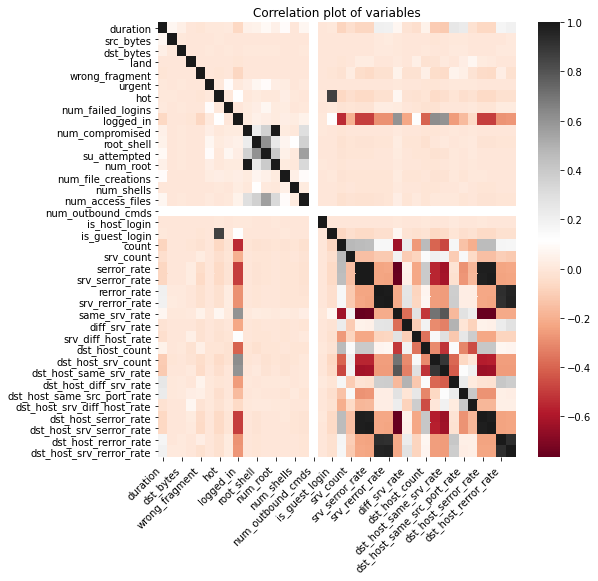

In [4]:
train_df_num = train_df[[col for col, dtype in zip(train_df.columns, train_df.dtypes=='object') if not dtype]]
corr_df = train_df_num.corr()

plt.figure(figsize=(8,8))
ax = sns.heatmap(
      corr_df, 
      cmap='RdGy'
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Correlation plot of variables');

In [5]:
# cor_vars = [col for col, cor in zip(corr_df.columns, ((abs(corr_df)>0.4) & (corr_df<1)).any()) if cor]
# train_df_min = train_df_num[cor_vars]

# sns.pairplot(train_df_min)

Some of the variables are highly correlated with each other.  
We can reduce the dimensions of the dataset using a dimensionality reduction technique such as PCA.

In [6]:
scaler = StandardScaler ()
train_df_num = scaler.fit_transform(train_df_num)

In [7]:
y_act = test_df['target']
test_df_num = test_df[[col for col, dtype in zip(test_df.columns, test_df.dtypes=='object') if not dtype]]
test_df_num = scaler.transform(test_df_num)

In [23]:
model = KMeans(n_clusters=2, random_state=512)
# fit model and predict clusters
model.fit(train_df_num)
yhat = model.predict(test_df_num)

In [24]:
#y_act.value_counts()

In [25]:
y_act_int1 = [1 if x=='attack' else 0 for x in y_act]
y_act_int2 = [0 if x=='attack' else 1 for x in y_act]

In [26]:
print(classification_report(y_act_int1, yhat))

              precision    recall  f1-score   support

           0       0.62      0.98      0.76      9711
           1       0.97      0.55      0.70     12833

    accuracy                           0.73     22544
   macro avg       0.80      0.76      0.73     22544
weighted avg       0.82      0.73      0.73     22544



In [27]:
print(classification_report(y_act_int2, yhat))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41     12833
           1       0.03      0.02      0.02      9711

    accuracy                           0.27     22544
   macro avg       0.20      0.24      0.22     22544
weighted avg       0.23      0.27      0.25     22544



Above, we have selected 2 clusters, as we want to classify entries as either normal or attack.  
However, in unsupervised methods, we generally do not know the optimal number of clusters. There are various techniques that are used that try to find that number K, based on different criterions.  
A good overview of the most common methods is found [here](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad).  
It needs to be noted that it it usual to test with multiple methods, and select K that is the most common between all methods.  
Here, I will be using:
* Elbow method
* Gap statistic
* Silhouette score (for undersampled data, as it is a computationaly expensive method)


In [32]:
distortions = []
for k in range(2,15):
    model = KMeans(n_clusters=k, random_state=512)
    model.fit(train_df_num)
    distortions.append(model.inertia_)

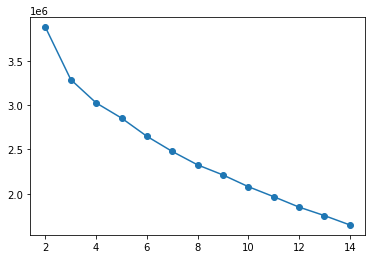

In [36]:
plt.plot(range(2,15), distortions, 'o-')
plt.show()

The more the clusters, the better?

In [44]:
model = KMeans(n_clusters=8, random_state=512, init='k-means++')
# fit model and predict clusters
model.fit(train_df_num)
yhat = model.predict(test_df_num)

In [111]:
accuracy_per_k = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_num)
    yhat = model.predict(test_df_num)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:18<00:00,  5.57s/it]


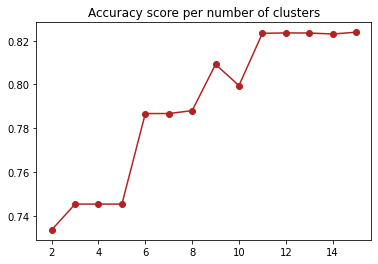

In [112]:
plt.plot(range(2,16), accuracy_per_k, 'o-', color='firebrick')
plt.title('Accuracy score per number of clusters');

### Numeric features + dimensionality reduction

In [118]:
from sklearn.decomposition import TruncatedSVD

In [138]:
#pca = PCA(n_components=20)
pca = TruncatedSVD(n_components=15)
train_df_pca = pca.fit_transform(train_df_num)
test_df_pca = pca.transform(test_df_num)
print(f'Explained variance ratio of 20 components: {pca.explained_variance_ratio_.sum()*100:.2f}%')

Explained variance ratio of 20 components: 80.90%


In [139]:
accuracy_per_k_pca_15 = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_pca)
    yhat = model.predict(test_df_pca)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k_pca_15.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:05<00:00,  4.66s/it]


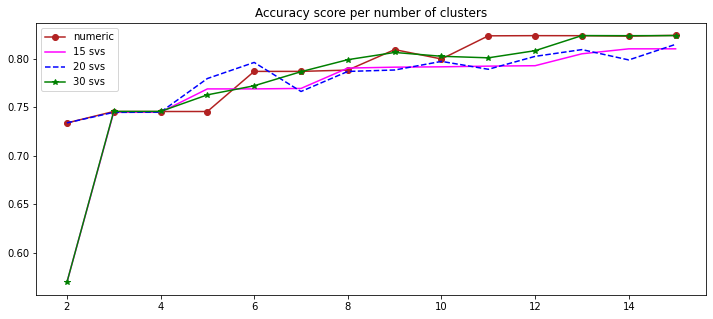

In [140]:
plt.figure(figsize=(12,5))
plt.plot(range(2,16), accuracy_per_k, 'o-', color='firebrick', label='numeric')
plt.plot(range(2,16), accuracy_per_k_pca_15, '-', color='magenta', label='15 svs')
plt.plot(range(2,16), accuracy_per_k_pca, '--', color='blue', label='20 svs')
plt.plot(range(2,16), accuracy_per_k_pca_30, '*-', color='green', label='30 svs')
plt.legend()
plt.title('Accuracy score per number of clusters');

### all numeric features + ohe the categorical ones

In [141]:
from sklearn.preprocessing import OneHotEncoder

In [142]:
drop_enc = OneHotEncoder(drop='first')

In [166]:
cat_cols = [x for x,y in zip(train_df.columns, train_df.dtypes=='object') if y]
train_df_cat = train_df[cat_cols]
test_df_cat = test_df[cat_cols]

In [169]:
train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

train_full = np.concatenate((train_df_num, train_ohe.todense()), axis=1)
test_full = np.concatenate((test_df_num, test_ohe.todense()), axis=1)

In [180]:
accuracy_per_k_cat = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_full)
    yhat = model.predict(test_full)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k_cat.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [01:04<00:00,  4.61s/it]


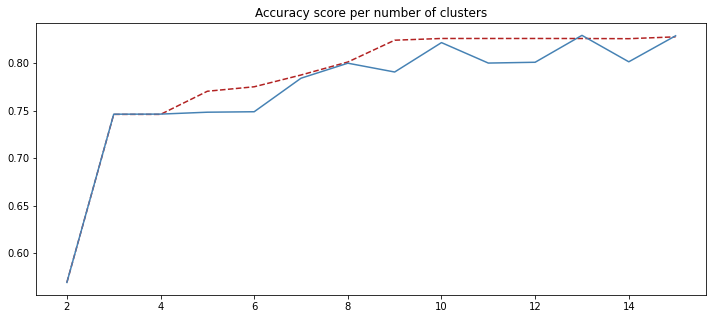

In [182]:
plt.figure(figsize=(12,5))
plt.plot(range(2,16), accuracy_per_k, '--', color='firebrick', label='all feats + ohe')
plt.plot(range(2,16), accuracy_per_k_cat, '-', color='steelblue', label='all - service + ohe')
plt.title('Accuracy score per number of clusters');

_service_ has many distinct values, test what happens if we omit it completely

In [179]:
train_df_cat = train_df[['protocol_type', 'flag']]
test_df_cat = test_df[['protocol_type', 'flag']]

train_ohe = drop_enc.fit_transform(train_df_cat)
test_ohe = drop_enc.transform(test_df_cat)

train_full = np.concatenate((train_df_num, train_ohe.todense()), axis=1)
test_full = np.concatenate((test_df_num, test_ohe.todense()), axis=1)

### use only a subset of the training dataset

In [184]:
from sklearn.model_selection import train_test_split

In [211]:
X_train, _ = train_test_split(train_df, test_size=0.70, random_state=58)

In [212]:
train_df_num = X_train[[col for col, dtype in zip(X_train.columns, X_train.dtypes=='object') if not dtype]]

scaler = MinMaxScaler()
train_df_num = scaler.fit_transform(train_df_num)

In [214]:
accuracy_per_kmm_30 = []

for k in tqdm(range(2, 16)):
    model = KMeans(n_clusters=k, random_state=512, init='k-means++')
    # fit model and predict clusters
    model.fit(train_df_num)
    yhat = model.predict(test_df_num)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_kmm_30.append(accuracy_score(y_act_int1, pred_class))

100%|██████████| 14/14 [00:45<00:00,  3.22s/it]


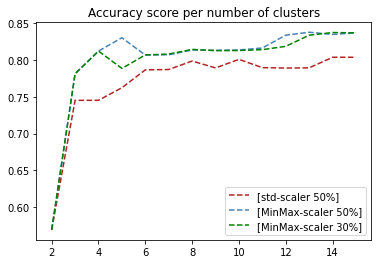

In [215]:
plt.plot(range(2,16), accuracy_per_k, '--', color='firebrick', label='[std-scaler 50%]')
plt.plot(range(2,16), accuracy_per_kmm, '--', color='steelblue', label='[MinMax-scaler 50%]')
plt.plot(range(2,16), accuracy_per_kmm_30, '--', color='green', label='[MinMax-scaler 30%]')
plt.legend()
plt.title('Accuracy score per number of clusters');

In [216]:
from sklearn.cluster import AgglomerativeClustering

In [210]:
model = AgglomerativeClustering(n_clusters=2)
# fit model and predict clusters
model.fit(train_df_num)
yhat = model.predict(test_df_num)

MemoryError: Unable to allocate 14.8 GiB for an array with shape (1983586605,) and data type float64

In [208]:
accuracy_per_k_hc = []

for k in tqdm(range(2, 16)):
    model = AgglomerativeClustering(n_clusters=k)
    # fit model and predict clusters
    model.fit(train_df_num)
    yhat = model.predict(test_df_num)

    pred_class = [np.nan]*len(y_act_int1)
    for n in range(k):
        clust=[x if x==n else np.nan for x in yhat]
        clust_values = [x for x,y in zip(y_act_int1, clust) if y==n]
        n_attacks = sum(clust_values)
        n_normal = len(clust_values) - n_attacks

        if n_attacks >= n_normal:
            clust = [1 if x==n else x for x in clust]
        else:
            clust = [0 if x==n else x for x in clust]

        # update the predicted class
        pred_class = np.nansum([pred_class, clust], axis=0)

    accuracy_per_k_hc.append(accuracy_score(y_act_int1, pred_class))

  0%|          | 0/14 [00:00<?, ?it/s]


MemoryError: Unable to allocate 14.8 GiB for an array with shape (1983586605,) and data type float64